# Vorlesung 2: Lage, Streuung und Verteilungsform
*Ziel: Zentrum und Streuung sauber beschreiben, Ausreißer prüfen, Verteilungen lesen*

In [ ]:
# Code setup für VL2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

csv_path = "OECD.WISE.WDP,DSD_HSL@DF_HSL_CWB,+all.csv"
df = pd.read_csv(csv_path, low_memory=False)

unnamed_cols = [c for c in df.columns if "unnamed" in c.lower()]
if unnamed_cols:
    df = df.drop(columns=unnamed_cols)

df = df.rename(
    columns={
        "REF_AREA": "country",
        "MEASURE": "measure",
        "UNIT_MEASURE": "unit",
        "TIME_PERIOD": "year",
        "OBS_VALUE": "value",
    }
)

df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["value"] = pd.to_numeric(df["value"], errors="coerce")
for cat_col in ("country", "measure", "unit"):
    if cat_col in df.columns:
        df[cat_col] = df[cat_col].astype("category")

s = df["value"].dropna()

mean_ = s.mean()
median_ = s.median()
mode_series = s.mode()
mode_ = mode_series.iloc[0] if not mode_series.empty else float("nan")
q1, q2, q3 = s.quantile([0.25, 0.50, 0.75])

p_trim = 0.10
s_sorted = s.sort_values().to_numpy()
k_trim = int(len(s_sorted) * p_trim)
trimmed_mean = s_sorted[k_trim : len(s_sorted) - k_trim].mean() if len(s_sorted) > 2 * k_trim else float("nan")

sd = s.std(ddof=1)
var_ = s.var(ddof=1)
iqr = q3 - q1
mad = (s - median_).abs().median()
mad_sigma = 1.4826 * mad

lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
mask_tukey = (s < lo) | (s > hi)

M = 0.6745 * (s - median_) / (mad if mad != 0 else float("nan"))
mask_modz = M.abs() > 3.5

s_without_tukey = s[~mask_tukey]
p99 = s.quantile(0.99)
s_zoom = s[s <= p99]


In [5]:
# Auswahl der Zielwerte als Serie ohne fehlende Werte

s = df["value"].dropna()
len(s), s.head()

(108088,
 0    68.428571
 1    68.428571
 2    68.428571
 3    68.428571
 4    68.428571
 Name: value, dtype: float64)

In [6]:
# Berechnung von Lagekennzahlen: Mittelwert, Median, Modus, Quartile

mean_   = s.mean()
median_ = s.median()
mode_   = s.mode().iloc[0] if not s.mode().empty else float("nan")
q1, q2, q3 = s.quantile([0.25, 0.50, 0.75])

print("Mittelwert:", mean_)
print("Median:", median_)
print("Modus:", mode_)
print("Quartile:", {"Q1": q1, "Q2/Median": q2, "Q3": q3})


Mittelwert: 796.3451881063945
Median: 21.48532317
Modus: 0.0
Quartile: {'Q1': 7.51182370425, 'Q2/Median': 21.48532317, 'Q3': 71.0}


In [7]:
# Berechnung eines getrimmten Mittelwerts (robust gegen Ausreißer, z.B 10%)

p = 0.10  # 10% Trim
s_sorted = s.sort_values().to_numpy()
k = int(len(s_sorted) * p)
trimmed_mean = s_sorted[k:len(s_sorted)-k].mean() if len(s_sorted) > 2*k else float("nan")
print("Getrimmter Mittelwert (10%):", trimmed_mean)


Getrimmter Mittelwert (10%): 33.50086109866756


In [8]:
# Berechnung von Streuungsmaßen: Standardabweichung, Varianz, IQR und MAD (robust)

sd   = s.std(ddof=1)      # Stichprobe
var_ = s.var(ddof=1)
iqr  = q3 - q1
mad  = (s - median_).abs().median()
mad_sigma = 1.4826 * mad  # auf SD-Skala skaliert

print("Standardabweichung:", sd)
print("Varianz:", var_)
print("IQR:", iqr)
print("MAD:", mad, "| MAD (skaliert):", mad_sigma)


Standardabweichung: 8781.589718170015
Varianz: 77116317.97826931
IQR: 63.48817629575
MAD: 17.84801016 | MAD (skaliert): 26.461459863216


In [9]:
# Markierung von Ausreißern mit Tukey-Regel (1.5×IQR) und modifiziertem Z-Score (über MAD)

# Tukey-Fences
lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
mask_tukey = (s < lo) | (s > hi)

# Modifizierter Z-Score (|M| > 3.5)
M = 0.6745 * (s - median_) / (mad if mad != 0 else float("nan"))
mask_modz = M.abs() > 3.5

print("Ausreißer-Kandidaten (Tukey):", int(mask_tukey.sum()))
print("Ausreißer-Kandidaten (mod. Z):", int(mask_modz.sum()))


Ausreißer-Kandidaten (Tukey): 4015
Ausreißer-Kandidaten (mod. Z): 4020


In [10]:
# Vergleich der Kennzahlen mit und ohne Tukey-Ausreißer

s_wo = s[~mask_tukey]

print("Mit Ausreißern  → Mean/SD :", mean_, sd)
print("Ohne Ausreißer → Mean/SD :", s_wo.mean(), s_wo.std(ddof=1))

print("Mit Ausreißern  → Median/IQR :", median_, iqr)
print("Ohne Ausreißer → Median/IQR :", s_wo.median(), s_wo.quantile(.75) - s_wo.quantile(.25))


Mit Ausreißern  → Mean/SD : 796.3451881063945 8781.589718170015
Ohne Ausreißer → Mean/SD : 34.096711450552775 31.79810502642339
Mit Ausreißern  → Median/IQR : 21.48532317 63.48817629575
Ohne Ausreißer → Median/IQR : 19.79 58.17108368


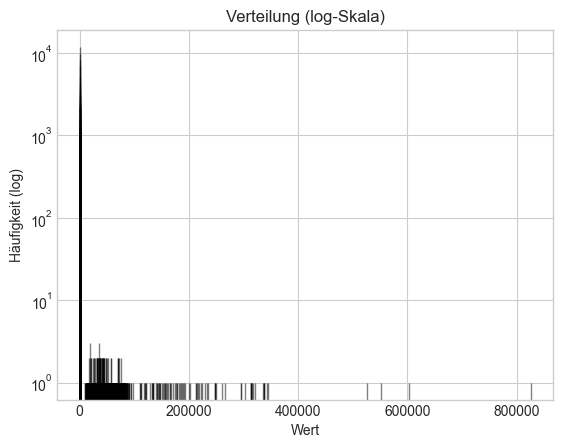

In [11]:
# Darstellung der Verteilung mit Log-Skala, um niedrige und hohe Werte sichtbar zu machen

plt.figure()
plt.hist(s, bins="fd", edgecolor="black", alpha=0.5)
plt.yscale("log")
plt.title("Verteilung (log-Skala)")
plt.xlabel("Wert"); plt.ylabel("Häufigkeit (log)")
plt.show()


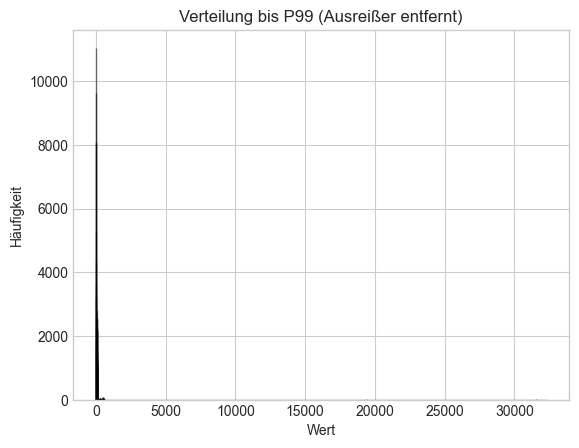

In [12]:
# Entfernung extremer Werte (z. B. Top 1 %) und erneute Darstellung

# Grenzwert Top-1-Prozent
p99 = s.quantile(0.99)
s_zoom = s[s <= p99]

plt.figure()
plt.hist(s_zoom, bins="fd", edgecolor="black", alpha=0.5)
plt.title("Verteilung bis P99 (Ausreißer entfernt)")
plt.xlabel("Wert"); plt.ylabel("Häufigkeit")
plt.show()



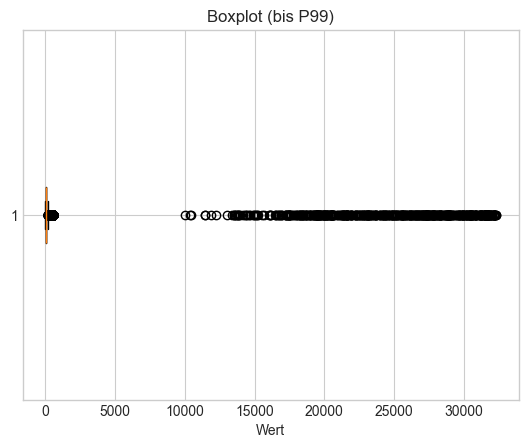

In [13]:
# Boxplot zur Visualisierung von Median, IQR und Ausreißern

plt.figure()
plt.boxplot(s_zoom, vert=False)
plt.title("Boxplot (bis P99)")
plt.xlabel("Wert")
plt.show()


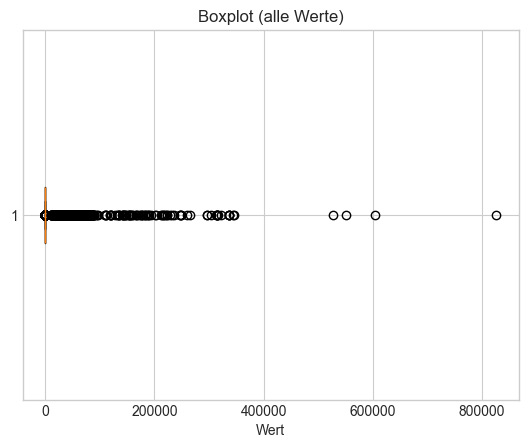

In [14]:
# Vergleich: Boxplot mit allen Werten (zeigt extreme Ausreißer deutlich)

plt.figure()
plt.boxplot(s, vert=False)
plt.title("Boxplot (alle Werte)")
plt.xlabel("Wert")
plt.show()
